# 15-12-23

Now that we've seen the centroid finding algorithm work on some images, we'd like to test it on as many as possible

In [1]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2,ifft2,fftshift
from speckle_fns import fits_import, circ_filter1
from speckle_fns import deconv0,deconv1, postprocess
from speckle_fns import filter_lpf, filter_hpf, filter_interference
import cv2

%matplotlib inline

In [2]:
fileDoubleStar = ['/home/niels/Documents/FITS/KP336_PSD.fits',
                  '/home/niels/Documents/FITS/KP339_PSD.fits',
                  '/home/niels/Documents/FITS/KP341_PSD.fits']
fileSingleStar = ['/home/niels/Documents/FITS/KP338_PSD.fits',
                  '/home/niels/Documents/FITS/KP340_PSD.fits',
                  '/home/niels/Documents/FITS/KP342_PSD.fits']


Filename: /home/niels/Documents/FITS/KP336_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   

Filename: /home/niels/Documents/FITS/KP338_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   



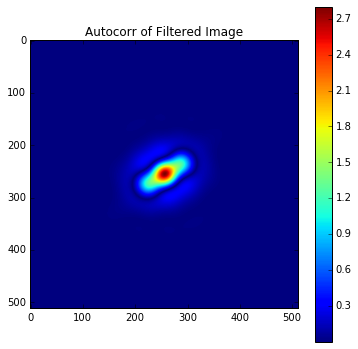

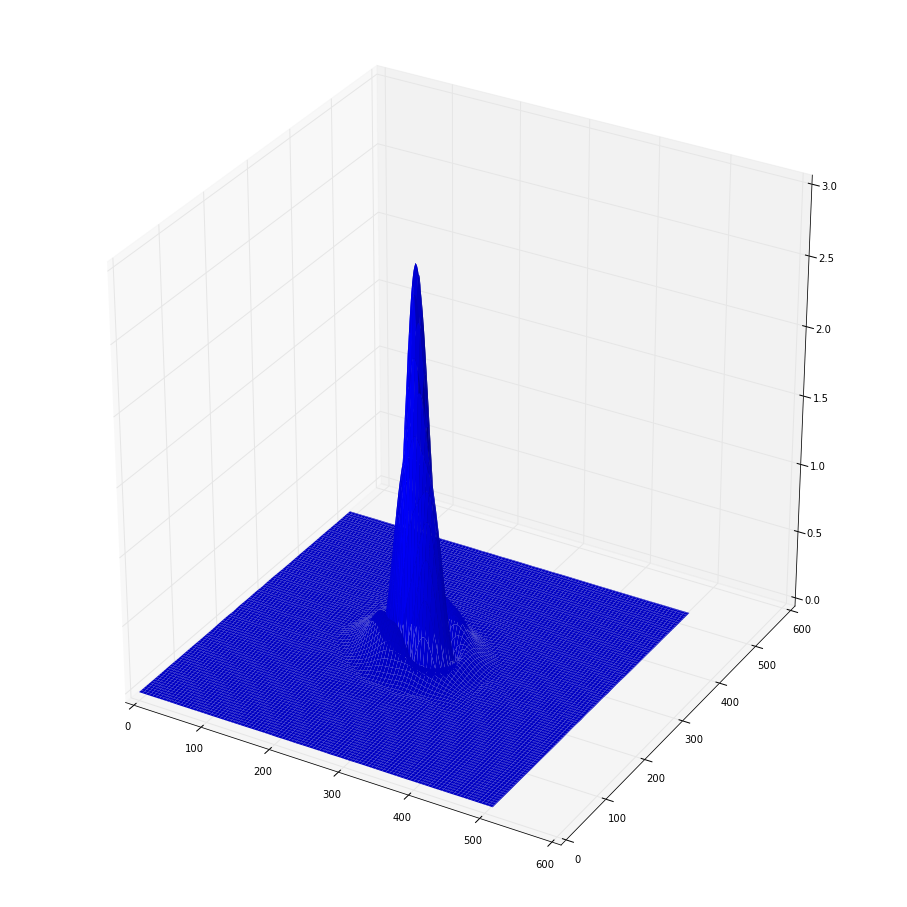

In [8]:
# Generating Autocorrelogram

# Import FITS file data
psdDoubleStar = fits_import(fileDoubleStar[0]).astype(float)
psdSingleStar = fits_import(fileSingleStar[0]).astype(float)

# Perform Deconvolution
constant = 1E-15
imgF = fftshift(deconv1(psdDoubleStar, psdSingleStar, constant))

# Filter PSD:
imgF_filtered = filter_interference(imgF)
imgF_filtered = filter_lpf(imgF_filtered, 5)
imgF_filtered = filter_hpf(imgF_filtered, 6, 0.8)

# Postprocess
img_autocorr = postprocess(imgF_filtered)

# Plot Image
plt.figure(figsize = (6,6))
plt.imshow(img_autocorr)
plt.title("Autocorr of Filtered Image")
plt.colorbar()

# Create variables for surface plot
x = np.arange(512)
y = np.arange(512)
x,y = np.meshgrid(x,y)
z = img_autocorr

# Plot surface plot 
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,y,z,rstride=5,cstride=5, linewidth=0)

In [ ]:
# Want to find the lowest threshold that we only see the 3 main lobes
autocorr = np.array(z)

# Start thresh at max value of autocorr (assuming that is from central peak)
threshold = np.floor(autocorr.max())

# Calculate values to increment/decrement threshold by depending on height of autocorrelogram
increment_coarse = autocorr.max()/10
increment_fine   = autocorr.max()/100

# Assume we start with 1 contour visible 
num_contours = 1

# Step down in steps of 5 until we have gone too far
while (num_contours < 4):
    # Decrement the threshold
    threshold = threshold - increment_coarse
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)

# Step back up in threshold until we are back to 3 contours
while (num_contours > 3):
    # Decrement the threshold
    threshold = threshold + increment_fine
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)    


# Calculate indices in image above threshold
above_thresh_i = autocorr > threshold
    
# Create thresholded image
autocorr_thresh = np.zeros(np.shape(autocorr))
autocorr_thresh[above_thresh_i] = 255
autocorr_thresh = autocorr_thresh.astype(np.uint8)

# Display results
print(threshold)
plt.figure(figsize=(8,8))
plt.imshow(autocorr_thresh)

## Now that we have the contours, we want to find their centroids for sorting purposes
centroid = np.zeros((3,2))

for i in np.arange(3):
    # Calculating Image Moment/Raw Moment of contour
    M = cv2.moments(contours[i])
    
    # Calculate centroid X and Y components 
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    centroid[i] = (cy, cx)
    
print(centroid)

## Find the central contour
# Center pixel indices
center = np.divide(np.shape(autocorr),2)
center_distance = np.zeros(3)

# Calculate distance from each centroid to center of image
for i in np.arange(3):
    center_distance[i] = np.linalg.norm(centroid[i] - center)

# Get index of central contour as contour with min distance to center
i = np.where(center_distance == center_distance.min())
i_center = i[0]

# Show central contour
mask_center = np.zeros(np.shape(autocorr))
cv2.drawContours(mask_center,contours,i_center,(1,1,1),-1)

plt.figure(figsize=(8,8))
plt.imshow(np.multiply(mask_center,autocorr))
plt.colorbar()

## Finding indices of side lobes
# Possible indices of side lobes
i_side_lobes = [0,1,2]
# Remove the center lobe index
i_side_lobes.remove(i_center)

# Make empty mask images
mask_side = np.zeros((2,np.shape(autocorr)[0],np.shape(autocorr)[1]))
lobe_side = np.zeros((2,np.shape(autocorr)[0],np.shape(autocorr)[1]))

# Create masks and calculate side lobes
for i in np.arange(2):
    cv2.drawContours(mask_side[i],contours,i_side_lobes[i],(1,1,1),-1)
    lobe_side[i] = (np.multiply(autocorr,mask_side[i]))#.astype(np.uint8)

# View both side lobes
plt.figure(figsize=(10,5))
for i in np.arange(2):
    plt.subplot(1,2,i+1)
    plt.imshow(lobe_side[i])
    plt.colorbar()
    
## Calculating intensity weighted centroid of side lobes

M00 = np.zeros((2))
M10 = np.zeros((2))
M01 = np.zeros((2))
centroid = np.zeros((2,2))

# Calculate for each side lobe
for lobe in np.arange(2):
    
    # Calculate average
    M00[lobe] = np.sum(lobe_side[lobe])
    
    # Calculate X component
    # Loop through each column
    for column in np.arange(np.shape(lobe_side[lobe])[1]):
        
        M10[lobe] += np.multiply(column,np.sum(lobe_side[lobe,:,column]))
        
        #print('X = ', column, np.multiply(column,np.sum(lobe_side[lobe,:,column])))
    
    # Calculate Y component
    # Loop through each column
    for row in np.arange(np.shape(lobe_side[lobe])[0]):
        
        M01[lobe] += np.multiply(row,np.sum(lobe_side[lobe,row,:]))
    
    # Calculate X and Y Centroid Components of each lobe
    centroid[lobe,0] = M10[lobe]/M00[lobe] # X Component
    centroid[lobe,1] = M01[lobe]/M00[lobe] # Y Component

# Print results of centroid finding
print(M00)
print(M10)
print(M01)
print(centroid[0,0], centroid[0,1])
print(centroid[1,0], centroid[1,1])

# Print original image with centroid locations overlayed
autocorr_cen = np.array(autocorr)
lobe_cen = np.array(lobe_side)

# Put lines on X coordinates of centroids
autocorr_cen[:,np.round(centroid[0,0]).astype(int)] = 0
autocorr_cen[:,np.round(centroid[1,0]).astype(int)] = 0
# Put lines on Y coordinates of centroids
autocorr_cen[np.round(centroid[0,1]).astype(int),:] = 0
autocorr_cen[np.round(centroid[1,1]).astype(int),:] = 0

# Put lines on sidelobe 0
lobe_cen[0,:,np.round(centroid[0,0]).astype(int)] = 0
lobe_cen[0,np.round(centroid[0,1]).astype(int),:] = 0

# Put lines on sidelobe 1
lobe_cen[1,:,np.round(centroid[1,0]).astype(int)] = 0
lobe_cen[1,np.round(centroid[1,1]).astype(int),:] = 0

# Graph all centroid marked plots
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.imshow(lobe_cen[0])
plt.title("Sidelobe 0 Centroid Location")

plt.subplot(1,3,2)
plt.imshow(lobe_cen[1])
plt.title("Sidelobe 1 Centroid Location")

plt.subplot(1,3,3)
plt.imshow(autocorr_cen)
plt.title("Both Sidelobe Centroid Locations")